In [1]:
import torch
import json
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import torch
from scipy.spatial.distance import cosine
from nltk.stem import WordNetLemmatizer
import matplotlib.patches as mpatches

In [2]:
# data loading (use DINet as an example)
model_name = 'dinet'
weight_direction = './log_'+model_name+'/'+'model.pth' # specifying the weights of the model
prototype = json.load(open('proto_dessection_result_'+model_name+'.json'))
saliency_weight = torch.load(weight_direction)
saliency_weight = saliency_weight['decoder.sal_decoder_1.weight'].squeeze(0).data.cpu().numpy()
# saliency_weight = saliency_weight['sal_layer_.weight'].squeeze(0).data.cpu().numpy()
# saliency_weight = saliency_weight['sal_cls_1.weight'].squeeze(0).data.cpu().numpy()

In [8]:
# compute the relative importance of different bases (regardless of spatial relationships)
# only consider the top-5 bases for each prototype
basis_weight = dict()
for i in range(len(prototype)):
    tmp_proto = dict()
    for idx, cur in enumerate(prototype[i]):
        tmp_proto[cur] = prototype[i][cur]
        if idx == 4:
            break
    total = np.sum(list(tmp_proto.values()))
    if total == 0:
        continue
    else:
        for cur in tmp_proto:
            tmp_proto[cur] /= total
        basis_weight[i] = tmp_proto

# measure the relative importance by multiplying saliency weights and basis weights
relative_importance = dict()
for i in range(len(saliency_weight)):
    if i not in basis_weight:
        continue
    cur_sal_weight = saliency_weight[i].sum()
    for basis in basis_weight[i]:
        if basis not in relative_importance:
            relative_importance[basis] = basis_weight[i][basis] * cur_sal_weight
        else:
            relative_importance[basis] += basis_weight[i][basis] * cur_sal_weight

relative_importance = {k:v for k,v in sorted(relative_importance.items(), key=lambda item:item[1], reverse=True)}
            
# compute the normalized importance (0-1)
max_importance = np.max(list(relative_importance.values()))
min_importance = np.min(list(relative_importance.values()))
denominator = np.max(list(relative_importance.values())) - np.min(list(relative_importance.values()))
norm_importance = dict()
for basis in relative_importance:
    norm_importance[basis] = (relative_importance[basis]-min_importance)/denominator

norm_importance = {k:v for k,v in sorted(norm_importance.items(), key=lambda item:item[1], reverse=True)}

# top-20 positive/negative bases
positive_importance = dict()
negative_importance = dict()
for basis in relative_importance:
    if relative_importance[basis]<0:
        negative_importance[basis] = -relative_importance[basis] # record flipped negative weights
    else:
        positive_importance[basis] = relative_importance[basis]

# normalize positive weights
norm_positive = dict()
positive_importance = {k:v for k,v in sorted(positive_importance.items(), key=lambda item:item[1], reverse=True)}
for idx, basis in enumerate(positive_importance):
    norm_positive[basis] = positive_importance[basis]
    if idx == 29: # consider top-30 semantics with positive/negative contributions
        break
max_pos = np.max(list(norm_positive.values()))
for basis in norm_positive:
    norm_positive[basis] /= max_pos

# normalize negative weights
norm_negative = dict()
negative_importance = {k:v for k,v in sorted(negative_importance.items(), key=lambda item:item[1], reverse=True)}
for idx, basis in enumerate(negative_importance):
    norm_negative[basis] = negative_importance[basis]
    if idx == 29:
        break
max_neg = np.max(list(norm_negative.values()))
for basis in norm_negative:
    norm_negative[basis] /= max_neg    

In [5]:
# parameters for plotting the contribution figure
bar_color = {'action': 'orangered', 
             'social': 'peachpuff', 
             'animal': 'gold', 
             'vehicle': 'greenyellow', 
             'clothing': 'aquamarine', 
             'text': 'cyan', 
             'sky': 'magenta', 
             'ground': 'darkviolet', 
             'scene': 'blue', 
             'other': 'silver', 
             'color': 'deepskyblue'}

basis2cat = {'having meeting': 'action',
 'face': 'social',
 'surfing': 'action',
 'goggles': 'clothing',
 'airplane': 'vehicle',
 'nose': 'social',
 'beard': 'social',
 'zebra': 'animal',
 'wetsuit': 'clothing',
 'jumping': 'action',
 'elephant': 'animal',
 'snowboarding': 'action',
 'skiing': 'action',
 'skateboarding': 'action',
 'head': 'social',
 'giraffe': 'animal',
 'double decker': 'vehicle',
 'train': 'vehicle',
 'written': 'text',
 'jersey': 'clothing',
 'blond': 'color',
 'tinted': 'color',
 'male': 'social',
 'mouth': 'social',
 'eye': 'social',
 'helmet': 'clothing',
 'teeth': 'social',
 'barefoot': 'clothing',
 'glowing': 'color',
 'street_sign': 'text',
 'street': 'scene',
 'turned': 'other',
 'dark brown': 'color',
 'hair': 'clothing',
 'coat': 'clothing',
 'gray': 'color',
 'cloudless': 'sky',
 'hazy': 'sky',
 'overcast': 'sky',
 'sky': 'sky',
 'cloudy': 'sky',
 'asphalt': 'ground',
 'park': 'scene',
 'paved': 'ground',
 'pavement': 'ground',
 'room': 'scene',
 'smiling': 'social',
 'happy': 'social',
 'ceiling': 'scene',
 'carpet': 'ground',
 'bathroom': 'scene',
 'field': 'ground',
 'road': 'ground',
 'curly': 'other',
 'posing': 'action',
 'kitchen': 'scene',
 'choppy': 'other',
 'balding': 'other',
 'tan': 'color',
 'wispy': 'other',
 'wall': 'scene',
 'hardwood': 'other',
 'asian': 'other',
 'floor': 'ground',
 'staring': 'action',
 'letter': 'text',
 'clear': 'other',
 'sleeveless': 'clothing',
 'young': 'other',
 'tied': 'other',
 'sunny': 'sky',
 'beach': 'scene',
 'table': 'other',
 'girl': 'social',
 'air': 'sky',
 'plain': 'ground',
 'fake': 'other',
 'sand': 'ground',
 'white': 'color',
 'glass': 'other',
 'gravel': 'ground',
 'dried': 'ground',
 'reflected': 'ground',
 'necklace': 'clothing',
 'still': 'other',
 'sandy': 'ground',
 'rough': 'other',
 'filled': 'other',
 'scarf': 'clothing',
 'outdoors': 'scene',
 'red': 'color',
 'collar': 'clothing',
 'purple': 'color',
 'shining': 'color',
 'curtain': 'other',
 'light blue': 'color',
 'man': 'social',
 'blind': 'other',
 'bald': 'other',
 'pale': 'color',
 'thick': 'other',
 'bus': 'vehicle',
 'blue': 'color',
 'huge': 'other',
 'monitor': 'other',
 'old': 'other',
 'straight': 'other',
 'skating': 'action',
 'black': 'color',
 'bed': 'other',
 'sitting': 'action',
 'dark blue': 'color',
 'flying': 'action',
 'resting': 'action',
 'kite': 'other',
 'horizontal': 'other',
 'toy': 'other',
 'knit': 'clothing',
 'sweater': 'clothing',
 'dry': 'other',
 'jacket': 'clothing',
 'small': 'other',
 'paint': 'other',
 'vintage': 'clothing',
 'tile': 'ground',
 'silver': 'color',
 'skier': 'action',
 'cloud': 'sky',
 'outstretched': 'other',
 'pizza': 'other',
 'wing': 'other',
 'tiny': 'other',
 'high': 'other',
 'donut': 'other',
 'clock': 'text',
 'ski': 'action',
 'sink': 'scene',
 'refrigerator':'scene',
 'wavy': 'other',
 'toaster': 'other',
 'plate': 'other',
 'window': 'scene',
 'neon': 'clothing',
 'rug': 'clothing',
 'ball': 'action',
 'lined': 'other',
 'tiled': 'ground',
 'digital':'other',
 'illuminated':'other',
 'metal':'other',
 'gold': 'color',
 'pretty': 'other',
 'overhead': 'other',
 'electric': 'other',
 'blurry': 'other',
 'brick': 'other',
 'hairy': 'other',
 'teal':'color',
 'pink':'color',
 'word': 'text',
 'printed': 'text',
 'doorway': 'scene',
 'bridge': 'other',
 'concrete': 'ground',
 'house': 'scene',
 'leafless': 'other',
 'leafy': 'other',
 'evergreen': 'color',
 'grassy': 'color',
 'camera': 'other',
 'graffiti':'text',
 'child':'social',
 'playing':'action',
 'crouching':'action',
 'roman':'other',
 'surfboard':'action',
 'short sleeved':'clothing',
 'vest':'clothing',
 'tower': 'clothing',
 'cooking': 'action',
 'light colored': 'color',
 'tent': 'other',
 'building': 'other',
 'lush': 'ground',
 'thin': 'other',
 'couch': 'other',
 'marble': 'ground',
 'men': 'social',
 'bushy': 'ground',
 'cracked': 'other',
 'busy': 'other'
}

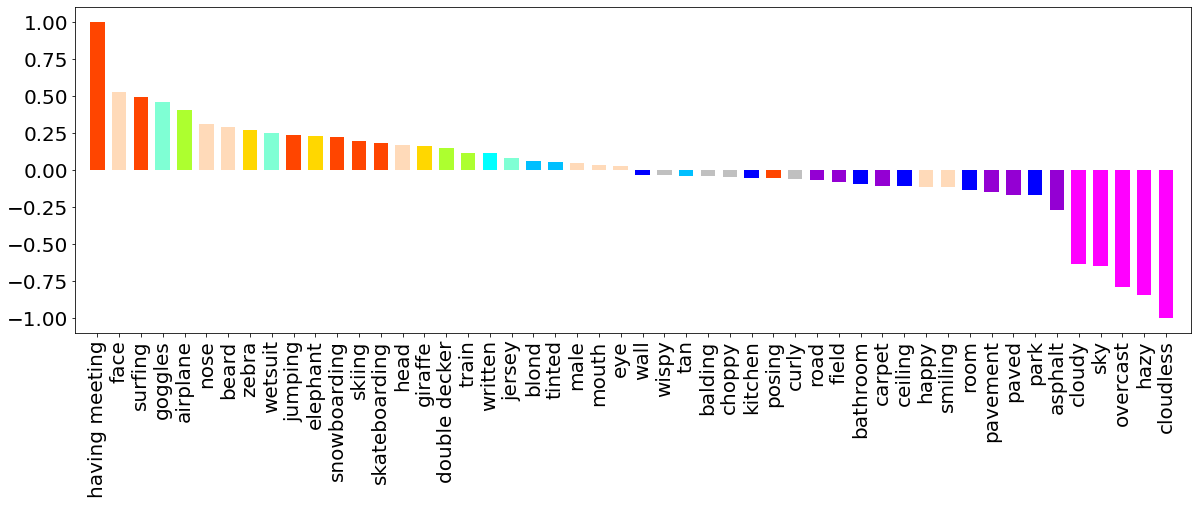

In [6]:
# plotting
# some semantics may not be included in the plotting parameters, need to manually add them to previous cell
invalid = [] 
norm_importance = []
basis_name = []
basis_color = []
plot_vertical = False
for cur in norm_positive:
    if cur not in basis2cat:
        invalid.append(cur)
        continue
    norm_importance.append(norm_positive[cur])
    basis_name.append(cur)
    basis_color.append(bar_color[basis2cat[cur]])

for cur in list(norm_negative.keys())[::-1]:
    if cur not in basis2cat:
        invalid.append(cur)
        continue
    norm_importance.append(-norm_negative[cur])
    basis_name.append(cur)
    basis_color.append(bar_color[basis2cat[cur]])

plt.close('all')
fig = plt.figure()
plt.bar(np.arange(len(basis_name))*1.2, norm_importance, color=basis_color)

# Create names on the x-axis
plt.xticks(np.arange(len(basis_name))*1.2, basis_name, fontsize=20, rotation = 90)
plt.yticks(fontsize=20)

plt.xlim(left=-1.2, right=60.2) # originally 72

fig.set_size_inches(20, 6)

# create legend
color_legend = []
for category in bar_color:
    color_legend.append(mpatches.Patch(color=bar_color[category], label=category))
plt.legend(handles=color_legend, fontsize=20, ncol=3)

# show graph
plt.show()

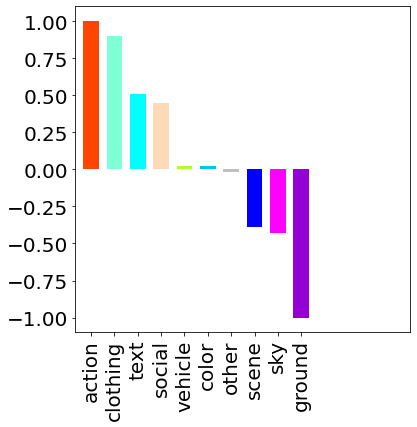

In [53]:
# plotting semantic category
invalid = []
norm_importance = []
basis_name = []
basis_color = []
cat_importance = dict()
for cur in norm_positive:
    cur_cat = basis2cat[cur]
    if cur_cat not in cat_importance:
        cat_importance[cur_cat] = 0
    cat_importance[cur_cat] += norm_positive[cur]


for cur in list(norm_negative.keys())[::-1]:
    cur_cat = basis2cat[cur]
    if cur_cat not in cat_importance:
        cat_importance[cur_cat] = 0
    cat_importance[cur_cat] += -norm_negative[cur]

max_val = np.max(list(cat_importance.values()))
min_val = np.abs(np.min(list(cat_importance.values())))

for cat in cat_importance:
    if cat_importance[cat]>0:
        cat_importance[cat]  /= max_val
    else:
        cat_importance[cat]  /= min_val
cat_importance = {k:v for k,v in sorted(cat_importance.items(), key=lambda item:item[1], reverse=True)}
    
for cat in cat_importance:
    norm_importance.append(cat_importance[cat])
    basis_name.append(cat)
    basis_color.append(bar_color[cat])

plt.close('all')
fig = plt.figure()
plt.bar(np.arange(len(basis_name))*1.2, norm_importance, color=basis_color)

# Create names on the x-axis
plt.xticks(np.arange(len(basis_name))*1.2, basis_name, fontsize=20, rotation = 90)
plt.yticks(fontsize=20)

# plt.xlim(left=-0.8)
plt.title('DINet', fontsize=20)
fig.set_size_inches(6, 6)